# **Tutorial for hierarchical Bayesian inference for Reinforcement Learning - Sequential Sampling Models.**

This is a (preview) tutorial for using the HSSM Python package to simultaneously estimate reinforcement learning parameters and decision parameters within a fully hierarchical bayesian estimation framework, including steps for constructing HSSM-compatible likelihoods/distributions and sampling from the posterior. Further, the plots to assess the recovery of model parameters are also shown. 

The module uses the reinforcement learning sequential sampling model (RLSSM), a reinforcement learning model that replaces the standard “softmax” choice function with a drift diffusion process with collapsing bounds (referred to as the 'angle' model hereon). The softmax and sequential sampling process is equivalent for capturing choice proportions, but the angle model also takes RT distributions into account; options are provided to also only fit RL parameters without RT. The RLSSM estimates trial-by-trial drift rate as a scaled difference in expected rewards (expected reward for upper bound alternative minus expected reward for lower bound alternative). Expected rewards are updated with a delta learning rule using either a single learning rate or with separate learning rates for positive and negative prediction errors. The model also includes the standard angle parameters. The broader RLSSM framework is described in detail in [Pedersen, Frank & Biele (2017)](https://ski.clps.brown.edu/papers/PedersenEtAl_RLDDM.pdf) and [Fengler, Bera, Pedersen & Frank (2022)](https://direct.mit.edu/jocn/article/34/10/1780/112585/Beyond-Drift-Diffusion-Models-Fitting-a-Broad).

In [1]:
# Import necessary libraries

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial
from scipy.stats import spearmanr
from ssms.basic_simulators.simulator import simulator

import pymc as pm
import pytensor.tensor as pt

import hssm
from hssm.utils import (decorate_atomic_simulator)
from hssm.likelihoods.rldm import make_rldm_logp_op
from hssm.distribution_utils.dist import make_hssm_rv

## Load the demo dataset. 
This data file contains (synthetic) data from a simulated 2-armed bandit task. We examine the dataset -- it contains the typical columns that are expected from a canonical instrumental learning task. `participant_id` identifies the subject id, `trial` identifies the sequence of trials within the subject data, `response` and `rt` are the data columns recorded for each trial, `feedback` column shows the reward obtained on a given trial and `correct` records whether the response was correct. 

In [4]:
savefile = np.load("../tests/fixtures/rldm_data.npy", allow_pickle=True).item()
dataset = savefile['data']

# Examine the dataset
dataset.head()

,participant_id,trial,response,rt,feedback,correct
0,0,0,0.0,0.935602,0.126686,0.0
1,0,1,0.0,1.114379,0.173100,0.0
2,0,2,0.0,0.564311,0.444935,0.0
3,0,3,0.0,2.885860,0.307207,0.0
4,0,4,0.0,0.532113,0.177911,0.0


In [ ]:
dataset, n_participants, n_trials = hssm.check_data_for_rl(dataset)

print(f"Number of participants: {n_participants}")
print(f"Number of trials: {n_trials}")

Number of participants: 20
Number of trials: 200


## Construct HSSM-compatible PyMC distribution from a simulator and JAX likelihood callable

We now construct a custom model that is compatible with HSSM and PyMC. Note that HSSM internally constructs a PyMC object (which is used for sampling) based on the user-specified HSSM model. In other words, we are peeling the abstration layers conveniently afforded by HSSM to directly use the core machinery of HSSM. This advanced [HSSM tutorial](https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/) explains how to use HSSM when starting from the very basics of a model -- a simulator and a JAX likelihood callable. 

The simulator function is used for generating samples from the model (for posterior predictives, etc.) and the likelihood callable is employed for sampling/inference. This preview tutorial exposes the key flexibility of the HSSM for use in fitting RLSSM models. Therefore, the subsequent tutorial will focus only on the sampling/inference aspect. We create a dummy simulator function to bypass the need for defining the actual simulator.

### Step 1: Define a pytensor RandomVariable

In [13]:
# Define the list of parameters to be used in the model
list_params = ['rl-alpha', 'scaler', 'a', 'z', 't', 'theta']

# create a dummy simulator function to be used with the decorator
def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):

    sim_rt = np.random.uniform(0.2, 0.6, n_samples)
    sim_ch = np.random.randint(0, 2, n_samples)

    return np.column_stack([sim_rt, sim_ch])

my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=simulator, model="custom", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(
    model_name="custom", choices=[0, 1, 2], obs_dim=2
)(my_wrapped_simulator)

# Step 1: Define a pytensor RandomVariable
# We use the `make_hssm_rv` function to create a custom RandomVariable that will be used in the PyMC model.
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=list_params
)

### Step 2: Define a likelihood function

In [9]:
# Step 2: Define a likelihood function
# We use the JAX function defined above to create a likelihood callable.
# The `make_likelihood_callable_rlssm` function is a utility that wraps the JAX function into a PyMC-compatible likelihood callable.
logp_jax_op = make_rldm_logp_op(
    n_participants=n_participants,
    n_trials=n_trials
)

### Step 3: Define a model config

In [14]:
# Step 3: Define the model config

model_config = hssm.ModelConfig(
    response=["rt", "response"],
    list_params=list_params,
    choices=[0, 1, 2],
    default_priors={},
    bounds=dict(rl_alpha=(0.01, 1), scaler=(2, 5), a=(0.3, 2.5), z=(0.1, 0.9), t=(0.1, 2.0), theta=(0.0, 1.2)),
    rv=CustomRV,
    extra_fields=["participant_id", "trial", "feedback"],
    backend="jax"
)

In [15]:
hssm_model = hssm.HSSM(
    data=dataset,
    model_config=model_config,
    p_outlier=0,
    lapse=None,
    loglik=logp_jax_op,
    loglik_kind="approx_differentiable",
    include=[
        hssm.Param("rl-alpha", formula="rl_alpha ~ 1", prior={"Intercept": hssm.Prior("Uniform", lower=0.01, upper=1)}),
        hssm.Param("scaler", formula="scaler ~ 1", prior={"Intercept": hssm.Prior("Uniform", lower=0.01, upper=1)}),
        hssm.Param("a", formula="a ~ 1", prior={"Intercept": hssm.Prior("Uniform", lower=0.01, upper=1)}),
        hssm.Param("z", formula="z ~ 1", prior={"Intercept": hssm.Prior("Uniform", lower=0.01, upper=1)}),
        hssm.Param("t", formula="t ~ 1", prior={"Intercept": hssm.Prior("Uniform", lower=0.01, upper=1)}),
        hssm.Param("theta", formula="theta ~ 1", prior={"Intercept": hssm.Prior("Uniform", lower=0.01, upper=1)}),
    ]
)

Model initialized successfully.


/Users/yxu150/HSSM/src/hssm/hssm.py:471: UserWarning: You set choices to be [0, 1, 2], but [2] are missing from your dataset.
  self._post_check_data_sanity()


In [16]:
hssm_model.sample()

Using default initvals. 



  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

arviz - WARNING - Array contains NaN-value.
/Users/yxu150/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/yxu150/HSSM/.venv/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 4000/4000 [00:14<00:00, 266.80it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Pass the test distribution to PyMC

In [12]:
# Define metadata for the model
num_subj = 20 
num_trials_per_subj = 200
ntrials = num_subj * num_trials_per_subj

# construct the PyMC model
with pm.Model() as model:

    # Group-level parameters
    group_rl_alpha_mean = pm.Uniform("group_rl_alpha_mean", lower=0.1, upper=1.0, initval=0.3)
    group_rl_alpha_sd = pm.Uniform("group_rl_alpha_sd", lower=0.0, upper=1.0)

    group_scaler_mean = pm.Uniform("group_scaler_mean", lower=1.0, upper=4.0, initval=1.5)
    group_scaler_sd = pm.Uniform("group_scaler_sd", lower=0.0, upper=1.0)

    group_a_mean = pm.Uniform("group_a_mean", lower=0.3, upper=2.5, initval=1.0)
    group_a_sd = pm.Uniform("group_a_sd", lower=0.0, upper=1.0)

    group_z_mean = pm.Uniform("group_z_mean", lower=0.10, upper=0.90, initval=0.2)
    group_z_sd = pm.Uniform("group_z_sd", lower=0.0, upper=1.0)

    group_t_mean = pm.Uniform("group_t_mean", lower=0.0, upper=2.0, initval=0.2)
    group_t_sd = pm.Uniform("group_t_sd", lower=0.0, upper=1.0)

    group_theta_mean = pm.Uniform("group_theta_mean", lower=0.0, upper=1.2, initval=0.3)
    group_theta_sd = pm.Uniform("group_theta_sd", lower=0.0, upper=1.0)

    # Non-centered parameterization using standard normal variables
    z_rl_alpha = pm.Normal("z_rl_alpha", mu=0, sigma=1, shape=num_subj)
    subj_rl_alpha = pm.Deterministic(
        "subj_rl_alpha",
        pm.math.clip(group_rl_alpha_mean + group_rl_alpha_sd * z_rl_alpha, 0.1, 1.0)
    )
    rl_alpha_det = pm.Deterministic("rl_alpha_det", pt.repeat(subj_rl_alpha, num_trials_per_subj))

    z_scaler = pm.Normal("z_scaler", mu=0, sigma=1, shape=num_subj)
    subj_scaler = pm.Deterministic(
        "subj_scaler",
        pm.math.clip(group_scaler_mean + group_scaler_sd * z_scaler, 1.0, 4.0)
    )
    scaler_det = pm.Deterministic("scaler_det", pt.repeat(subj_scaler, num_trials_per_subj))

    z_a = pm.Normal("z_a", mu=0, sigma=1, shape=num_subj)
    subj_a = pm.Deterministic(
        "subj_a",
        pm.math.clip(group_a_mean + group_a_sd * z_a, 0.3, 2.5)
    )
    a_det = pm.Deterministic("a_det", pt.repeat(subj_a, num_trials_per_subj))

    z_z = pm.Normal("z_z", mu=0, sigma=1, shape=num_subj)
    subj_z = pm.Deterministic(
        "subj_z",
        pm.math.clip(group_z_mean + group_z_sd * z_z, 0.10, 0.90)
    )
    z_det = pm.Deterministic("z_det", pt.repeat(subj_z, num_trials_per_subj))

    z_t = pm.Normal("z_t", mu=0, sigma=1, shape=num_subj)
    subj_t = pm.Deterministic(
        "subj_t",
        pm.math.clip(group_t_mean + group_t_sd * z_t, 0.0, 2.0)
    )
    t_det = pm.Deterministic("t_det", pt.repeat(subj_t, num_trials_per_subj))

    z_theta = pm.Normal("z_theta", mu=0, sigma=1, shape=num_subj)
    subj_theta = pm.Deterministic(
        "subj_theta",
        pm.math.clip(group_theta_mean + group_theta_sd * z_theta, 0.0, 1.2)
    )
    theta_det = pm.Deterministic("theta_det", pt.repeat(subj_theta, num_trials_per_subj))

    # load the data into the custom distribution
    participant_id = dataset["participant_id"].values.astype(np.float32)
    trial = dataset["trial"].values.astype(np.float32)
    response = dataset["response"].values.astype(np.float32)
    rt = dataset["rt"].values.astype(np.float32)
    feedback = dataset["feedback"].values.astype(np.float32)

    data_tensor = np.column_stack([rt, response])

    # create the custom distribution with the defined parameters and data
    CustomDistribution("custom", rl_alpha=rl_alpha_det, scaler=scaler_det, a=a_det, z=z_det, t=t_det, theta=theta_det, 
                       observed=data_tensor)

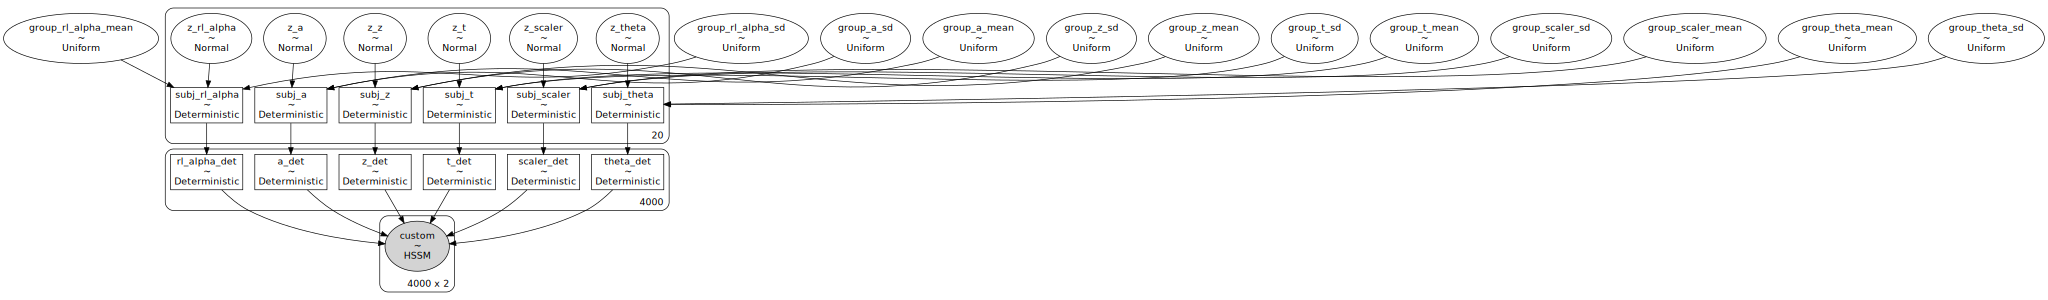

In [13]:
# visualize the model
pm.model_to_graphviz(model)

In [14]:
# sample from the model using NUTS sampler with NumPyro backend
with model:
    idata = pm.sample(draws=500, tune=1000, chains=1, nuts_sampler="numpyro")

sample: 100%|██████████| 1500/1500 [13:54<00:00,  1.80it/s, 31 steps of size 1.44e-01. acc. prob=0.91]   
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Assess the model fits

We examine the quality of fits by comparing the recovered parameters with the ground-truth data generating parameters of the simulated dataset. 
We examine the quality of fits both at group-level as well as subject-level.

In [15]:
# list of group-level parameters
var_names_group_mean = [
    "group_rl_alpha_mean",
    "group_scaler_mean",
    "group_a_mean",
    "group_z_mean",
    "group_t_mean", 
    "group_theta_mean",
]

In [16]:
# print the ground truth group means from the savefile
print("Ground truth group means:")
savefile['params_true_group']

Ground truth group means:


{'rl_alpha_mean': 0.6599748892148676,
 'rl_alpha_std': 0.03361741613298558,
 'scaler_mean': 2.784958224189237,
 'scaler_std': 0.11254334695285723,
 'a_mean': 1.4813726831343665,
 'a_std': 0.06833257048261644,
 'z_mean': 0.2669095905671848,
 'z_std': 0.029806013334481733,
 't_mean': 0.44266787531912977,
 't_std': 0.014493710805742526,
 'theta_mean': 0.31170111158943425,
 'theta_std': 0.03531698660560417}

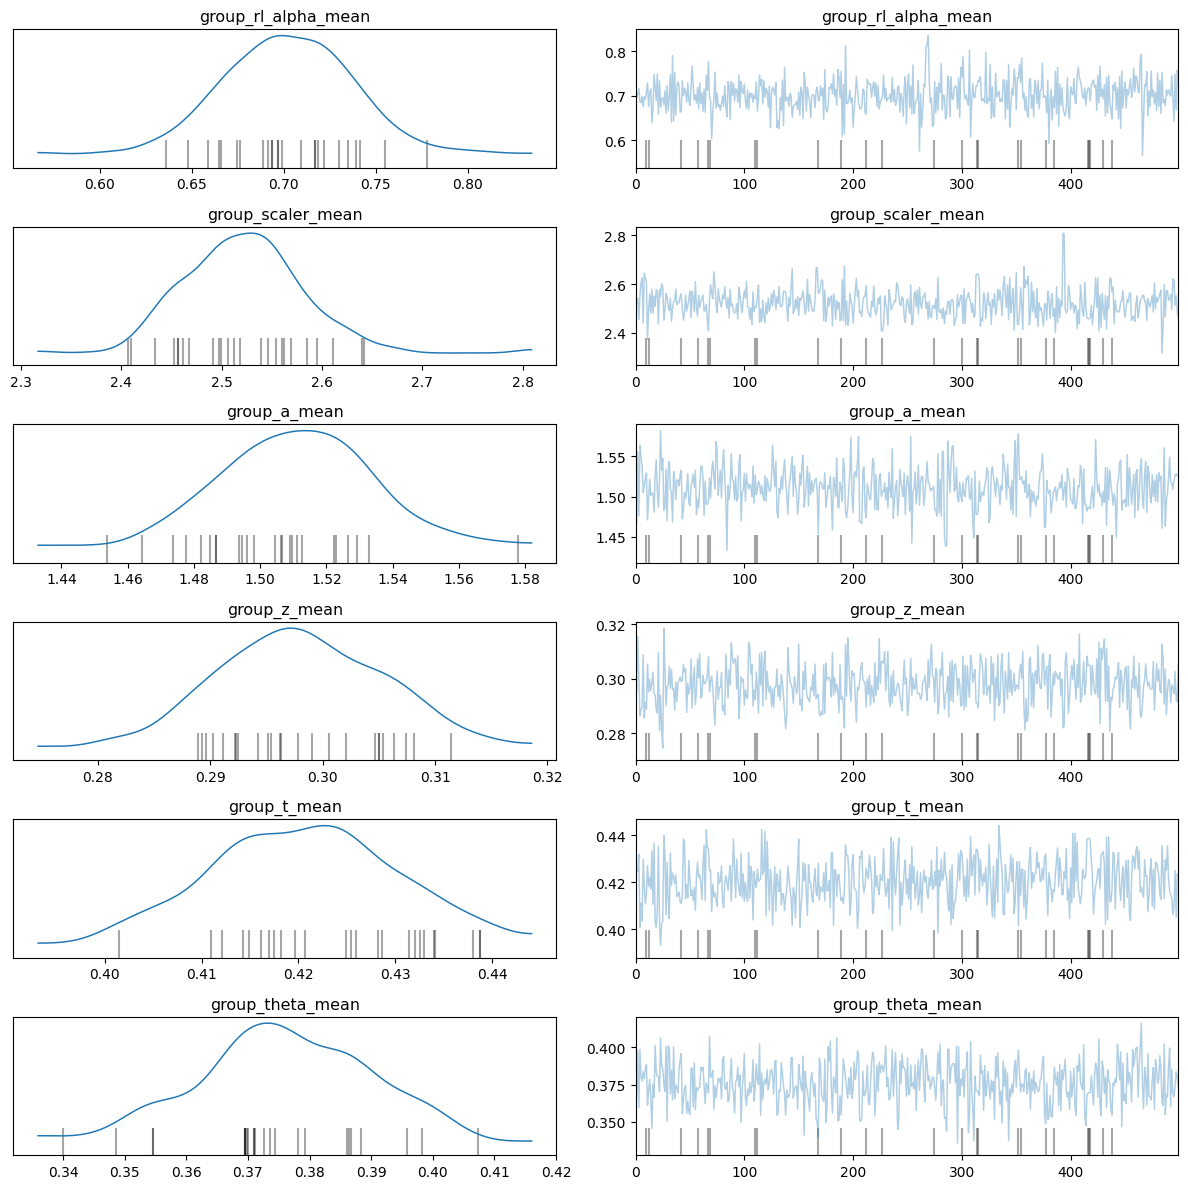

In [17]:
# plot the posterior distributions and traces of the group-level parameters
az.plot_trace(idata, var_names=var_names_group_mean)
plt.tight_layout()

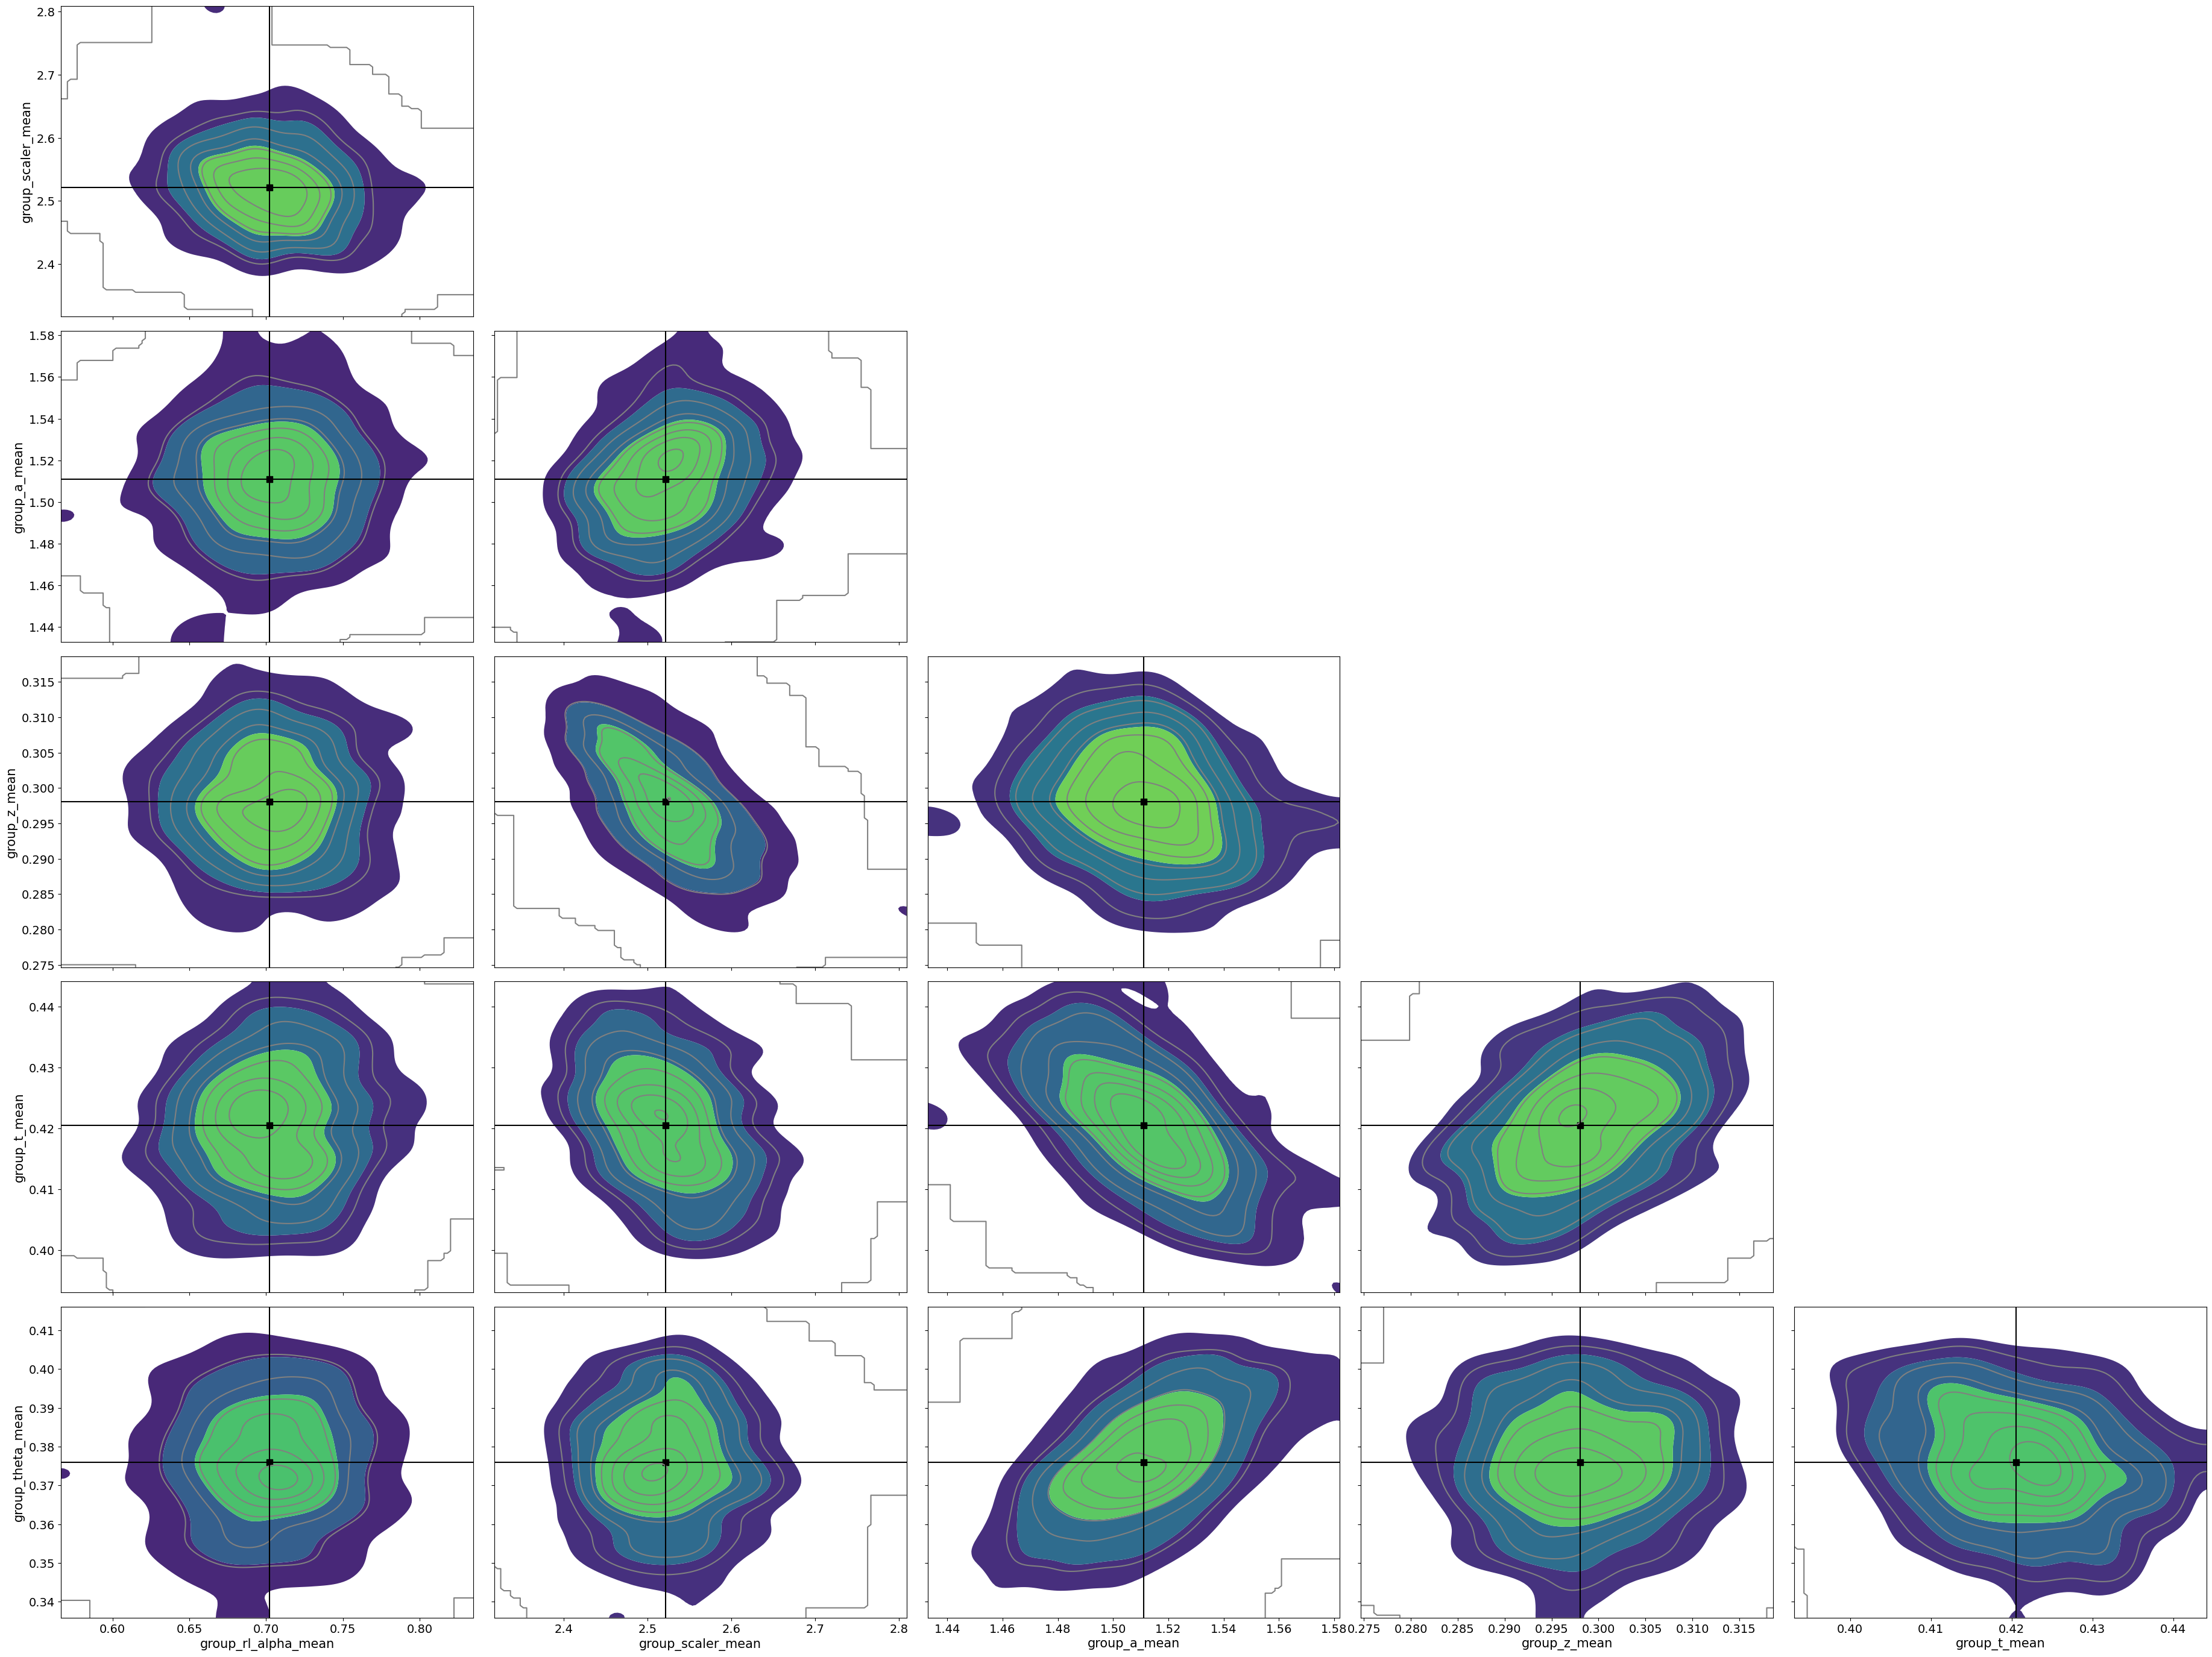

In [25]:
# plot the posterior pair plots of the group-level parameters
# this will show the joint distributions and correlations between the group-level parameters.
az.plot_pair(idata, var_names=var_names_group_mean, kind='kde', point_estimate='mean')
plt.tight_layout()

In [19]:
# transform the log_alpha parameter to its original scale
log_alpha_trace = idata.posterior["subj_rl_alpha"]
alpha_trace = np.exp(log_alpha_trace)
idata.posterior["subj_rl_alpha_orig"] = alpha_trace

In [20]:
# list of subject-level parameters
var_names_subj = [
    "subj_rl_alpha",
    "subj_scaler",
    "subj_a",
    "subj_z",
    "subj_t",
    "subj_theta",
]

In [21]:
# helper function to get the subject-level mean of the parameters from the posterior
def get_plot_data(posterior_idata, var_names_subj, hdi_prob=0.85):
    plot_data = {}
    for p_name in var_names_subj:
        if p_name == 'subj_alpha':
            access_p_name = 'subj_alpha_orig'
        else:
            access_p_name = p_name
        az_summary = az.summary(posterior_idata, var_names=[access_p_name], hdi_prob=hdi_prob, kind='stats', round_to=6)
        plot_data[p_name] = az_summary.values

        # get hdi columns in terms of the +/- range of mean (instead of the absolute values)
        plot_data[p_name][:, 2] = np.abs(plot_data[p_name][:, 2] - plot_data[p_name][:, 0])
        plot_data[p_name][:, 3] = np.abs(plot_data[p_name][:, 3] - plot_data[p_name][:, 0])
    
    return plot_data

In [22]:
plot_data = get_plot_data(idata, var_names_subj)

In [23]:
sim_param_list = np.zeros((20, 6))

for ind, p in enumerate(savefile['params_true_subj'].keys()):
    sim_param_list[:, ind] = savefile['params_true_subj'][p]

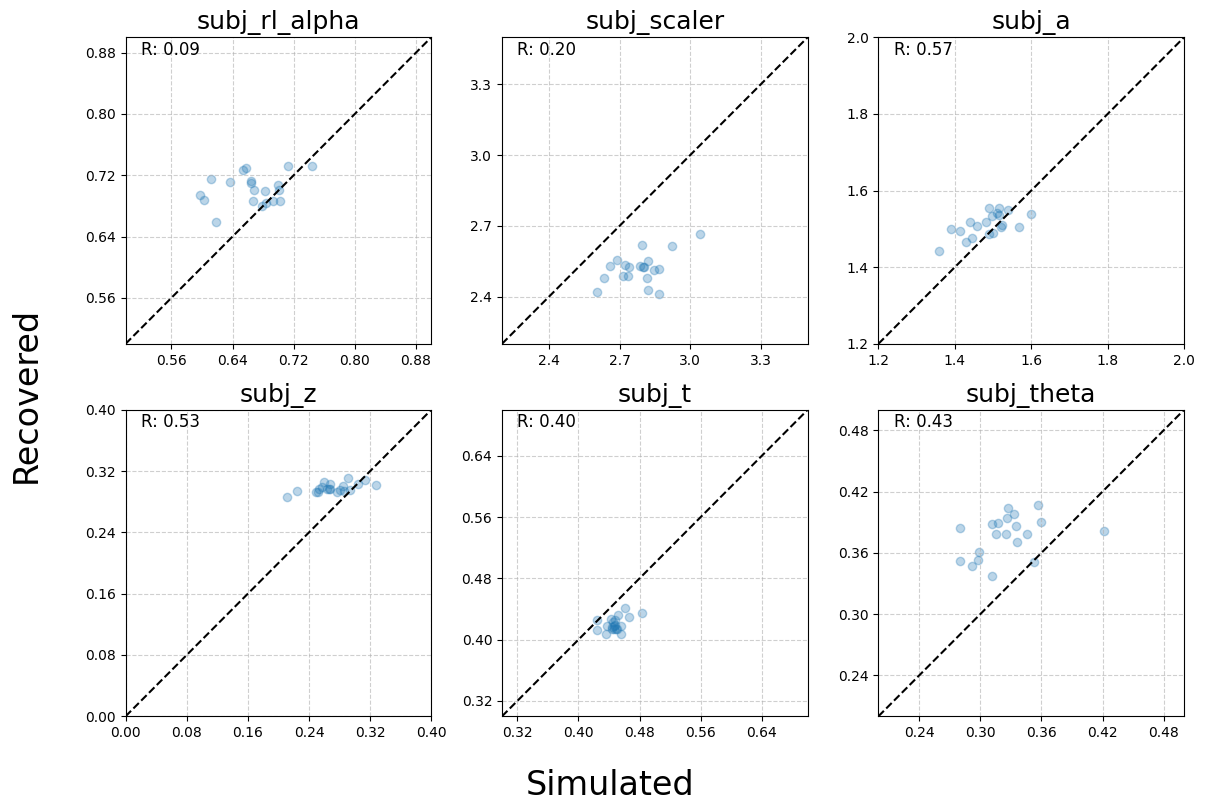

In [24]:
# plot the ground truth vs recovered parameters

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

axes_lims = [[0.5, 0.9], [2.2, 3.5], [1.2, 2], [0, 0.4], [0.3, 0.7], [0.2, 0.5]]

for i, ax in enumerate(axes):
    if i >= len(var_names_subj):
        ax.set_visible(False)
        continue

    x = sim_param_list[:, i]
    y = plot_data[var_names_subj[i]][:, 0]

    # Scatter plot 
    ax.scatter(x, y, alpha=0.3)

    # Calculate Spearman's R
    spearman_r, _ = spearmanr(x, y)

    # Add Spearman's R to the plot
    ax.text(0.05, 0.93, f"R: {spearman_r:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='bottom')

    # Customize subplot
    ax.set_title(var_names_subj[i], fontsize=18)
    ax.set_xlim(axes_lims[i])
    ax.set_ylim(axes_lims[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axline((0, 0), linestyle='--', slope=1, c='k')


fig.text(0.5, 0.00, 'Simulated', ha='center', fontsize=24)
fig.text(0.00, 0.5, 'Recovered', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()